## Initialising model and libraries

In [1]:
import sys
sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM, CelebA_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.utils.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch
import numpy as np
from pytorch_lightning import seed_everything

import seaborn as sns
import matplotlib.pyplot as plt


trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/CelebA/mamba/prod/Mamba_CelebA_prod__wp_1000_L_8_H_8_s_12_subset_False_08-04_18-48-33/last.ckpt'
dataset = trained_model_path.split('/')[-5]
model_type = trained_model_path.split('/')[-4]
loss = trained_model_path.split('/')[-3]

seed_everything(22122020)

if dataset == "MNIST":
    dm = MNIST_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=32, subset_flag=False)
if dataset == "CelebA":
    dm = CelebA_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=8, subset_flag=False)

dm.prepare_data()
dm.setup()
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
n_heads = 8
d_query = 32
model = SResTransformerModule(img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss=loss,
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query,num_shells = 5,
                              model_type = model_type)


weights = torch.load(trained_model_path)['state_dict']
model.load_state_dict(weights, strict=True)
model.cuda()
model.eval()
print('Model Loaded')

Seed set to 22122020


Model Loaded


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([2016, 2])


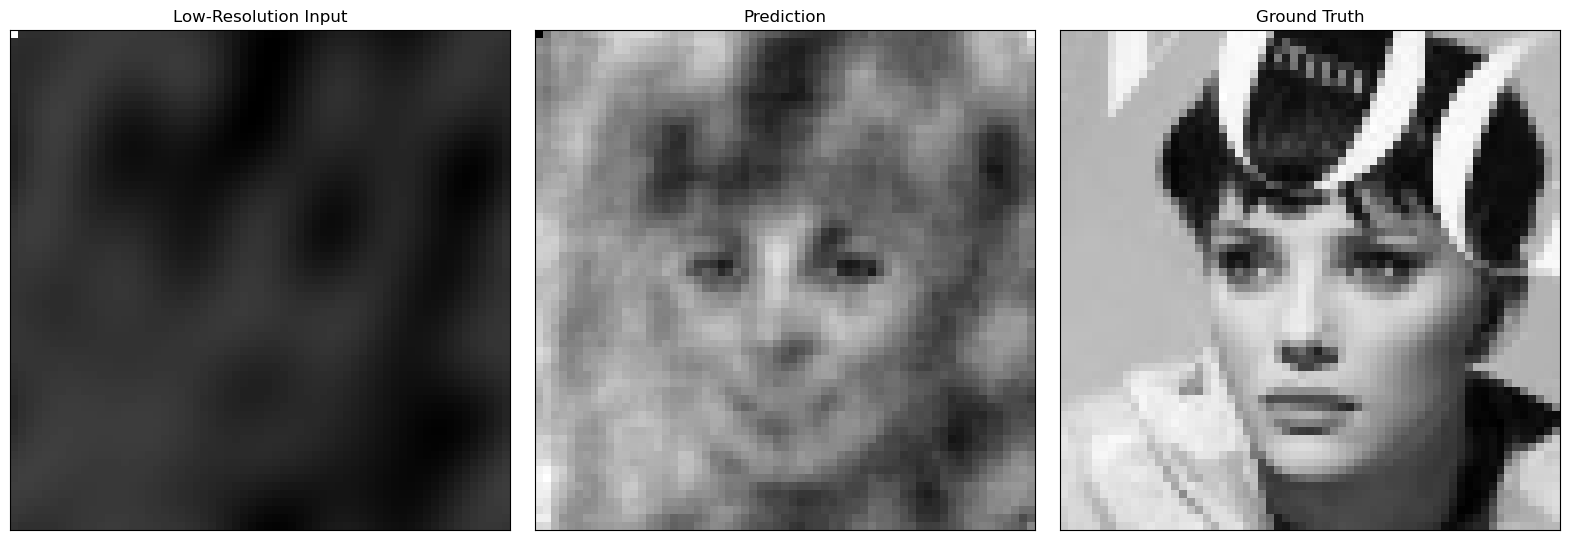

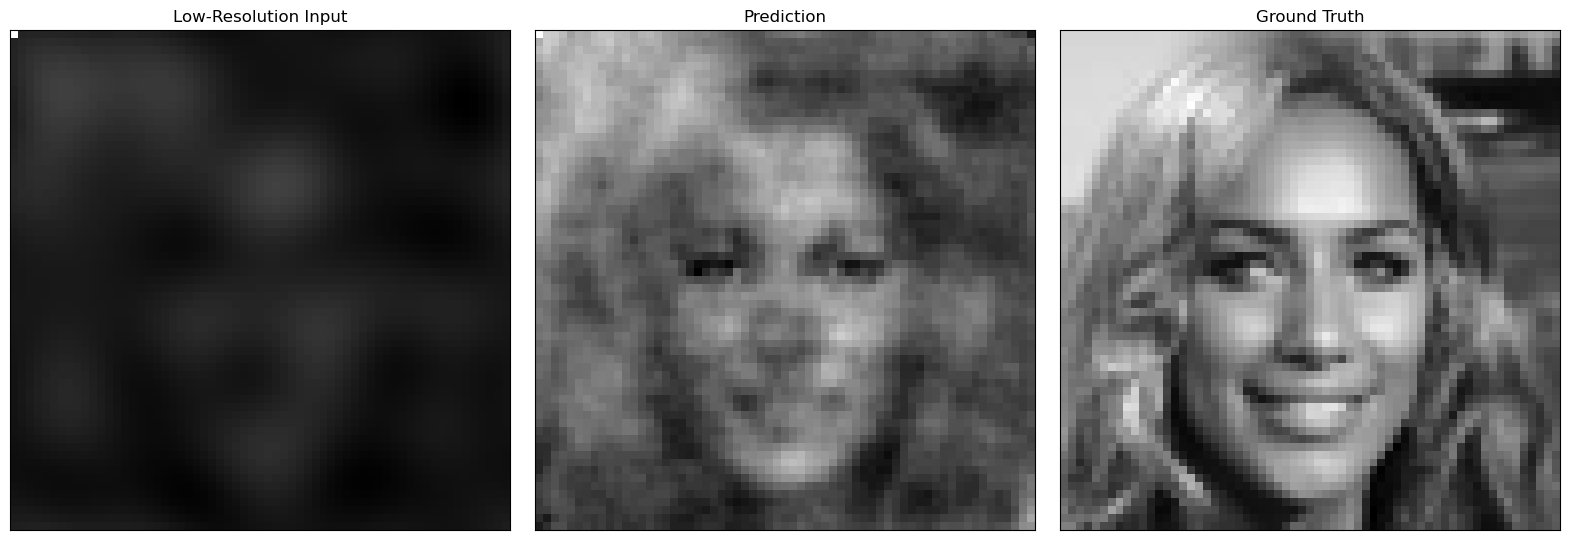

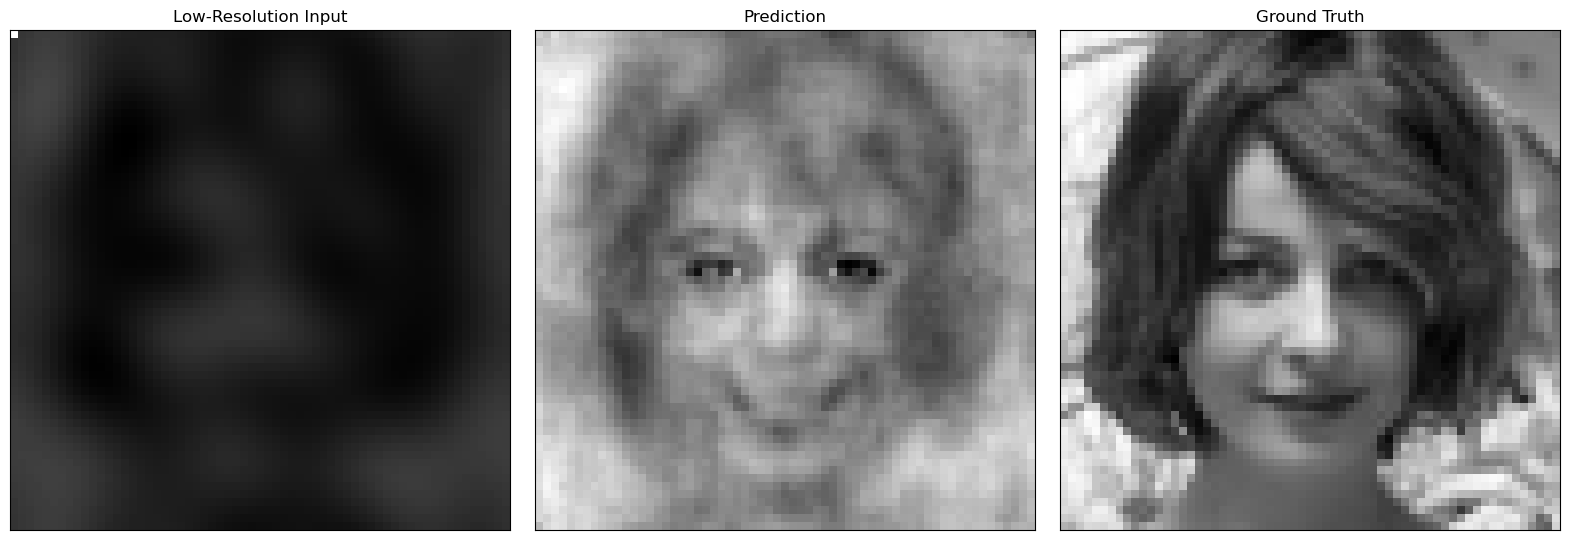

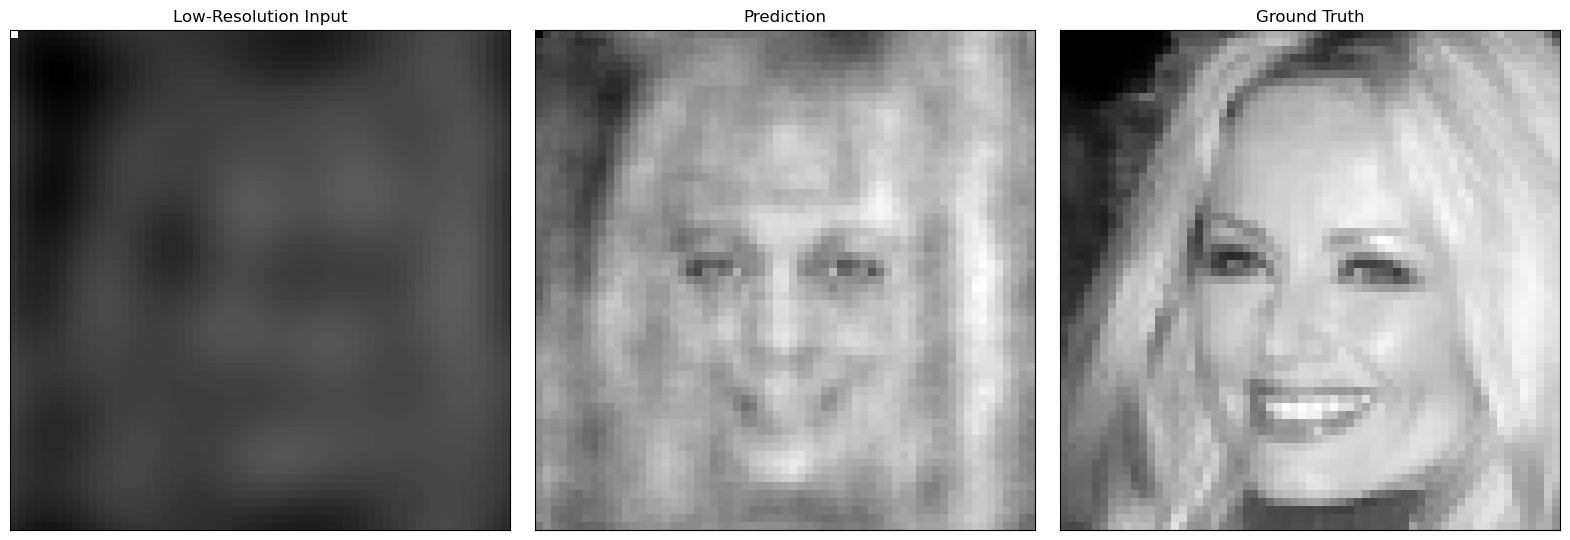

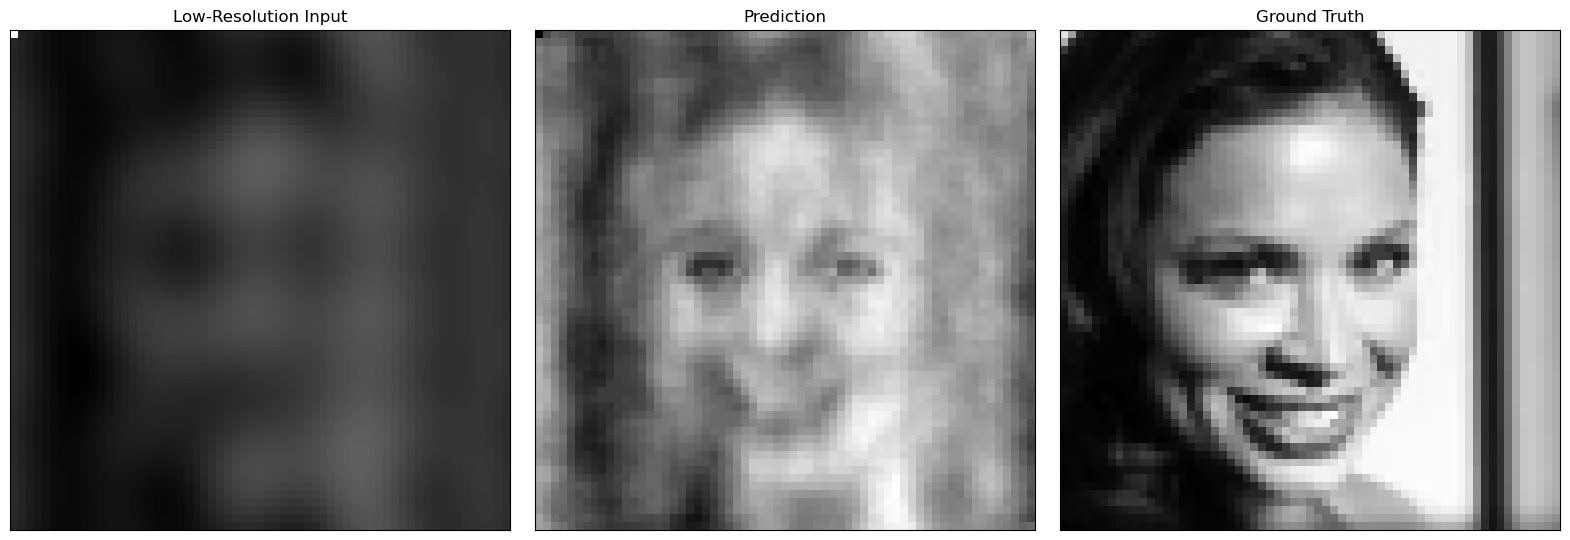

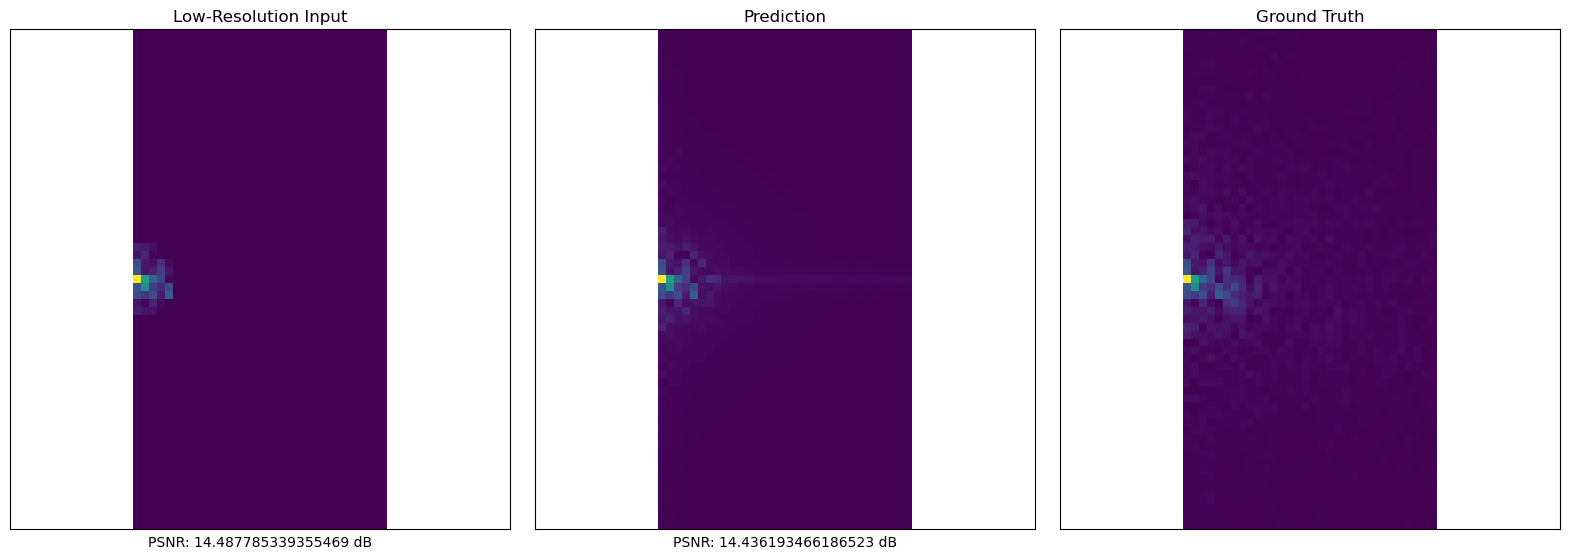

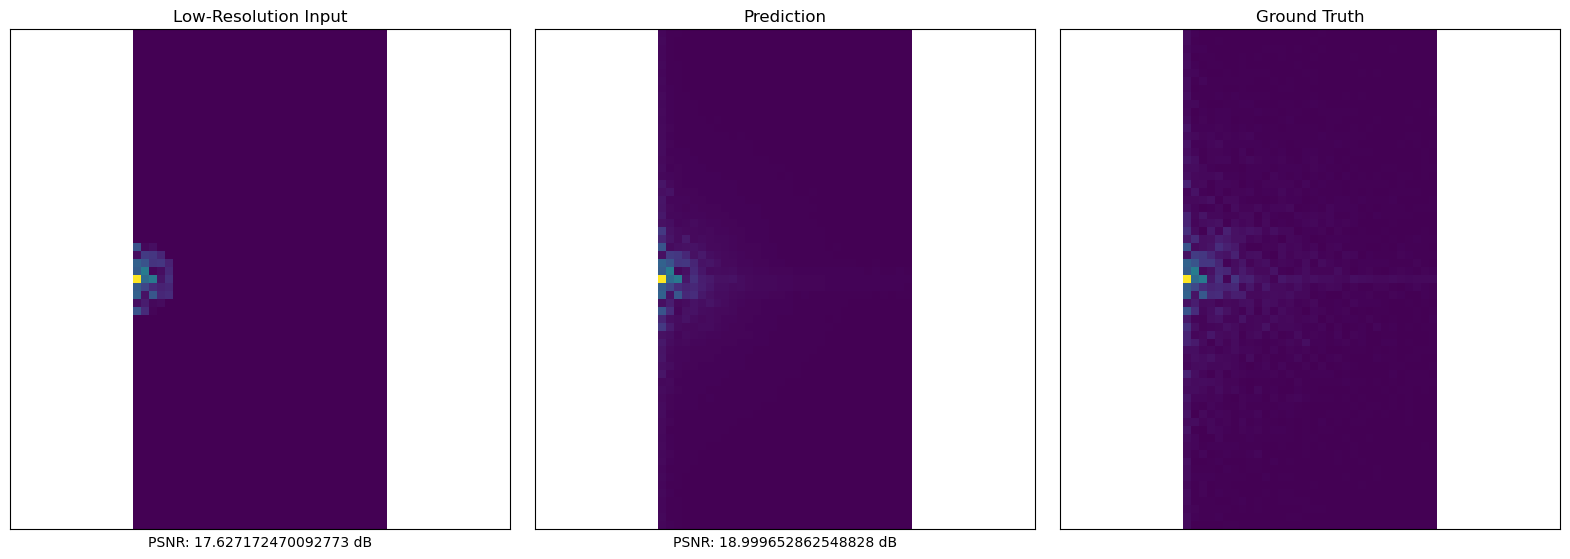

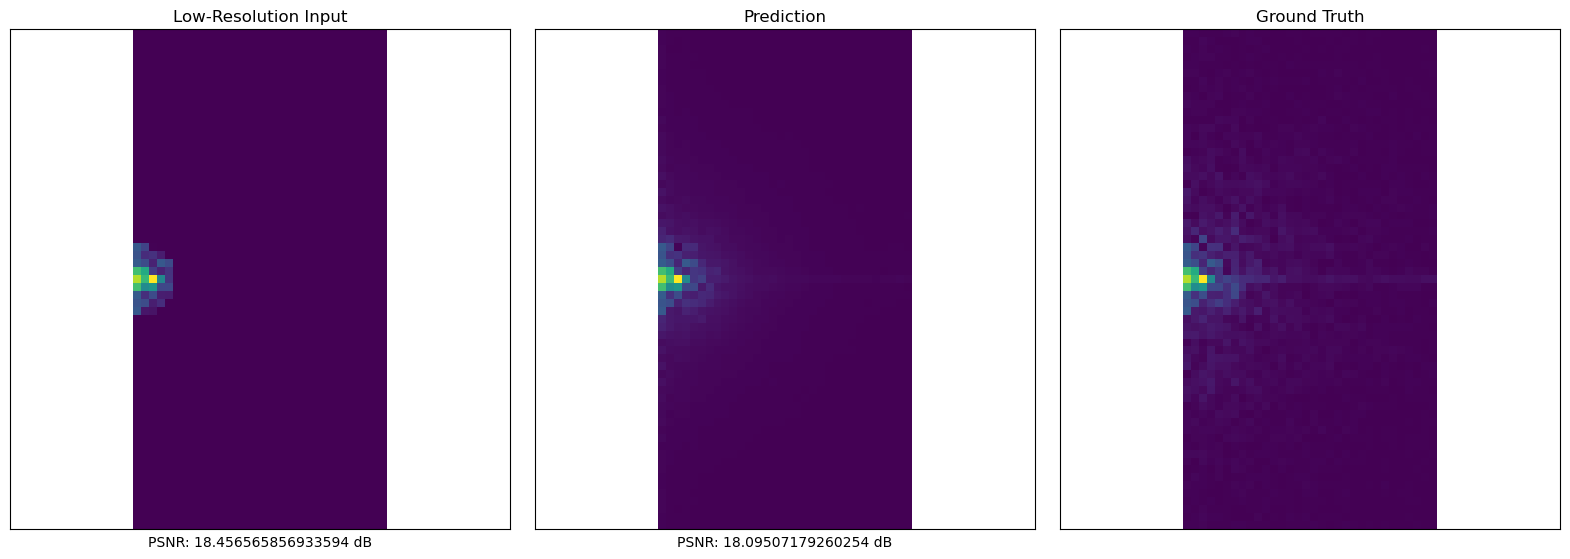

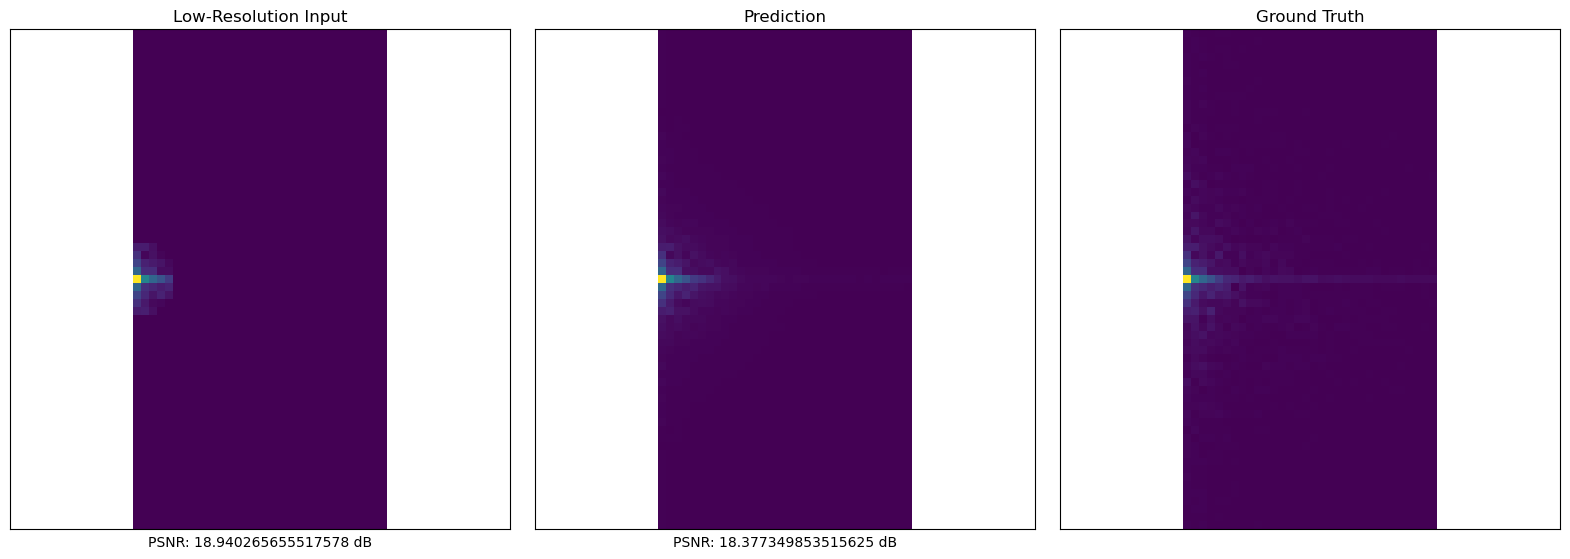

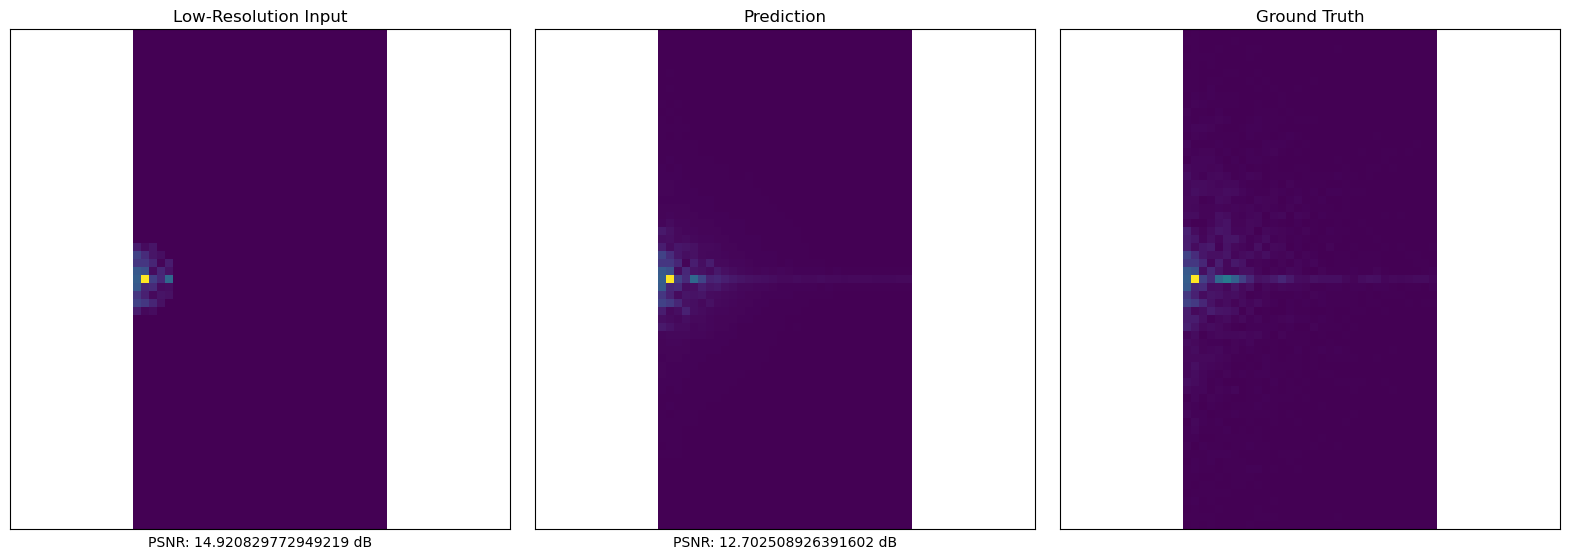

In [6]:
def predict_one_test_batch(no_of_images = 5):
    for fc, (mag_min, mag_max) in dm.test_dataloader():
        break

    fc = fc.to('cuda')
    mag_min = mag_min.to('cuda')
    mag_max = mag_max.to('cuda')
    x_input = fc[:, flatten_order][:, :model.input_seq_length]
    gt = fc[:, flatten_order]

    with torch.no_grad():
        pred = model.sres.forward_inference(x_input,max_seq_length=gt.shape[1])

    fig = plt.figure()
    lowres = torch.zeros_like(pred)
    lowres[:, :model.input_seq_length] = x_input
    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)
    lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=fc[:, model.dst_flatten_order], mag_min=mag_min, mag_max=mag_max)


    lowres_psnr = PSNR(gt_img,lowres_img)
    pred_psnr = PSNR(gt_img,pred_img)


    sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True )
    fig.legend()
    plt.savefig('psnr_diff.png')
    plt.close()
    for i in [pred_img, lowres_img, gt_img]:
        i.cpu().detach().numpy()
    for sample in range(no_of_images):
        fig2 = plt.figure(figsize=(31/2., 10/2.))
        gs = gridspec.GridSpec(1,5, width_ratios=[10,0.5, 10, 0.5, 10])
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)

        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
        ax0.set_title('Low-Resolution Input');
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(pred_img[sample].cpu(), cmap='gray')
        ax1.set_title('Prediction');
        ax1.axis('equal');


        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(gt_img[sample].cpu(), cmap='gray')
        ax2.set_title('Ground Truth');
        ax2.axis('equal');

    from sklearn.random_projection import sample_without_replacement


    for i in range(no_of_images):
        sample = i
        fig = plt.figure(figsize=(31/2., 10/2.))
        gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10])
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.axis('equal');

predict_one_test_batch(5)

In [3]:
# def make_figs(lowres_psnr, pred_psnr,save_folder,id):
#     font = {'family' : 'serif',
#         'weight': 'normal',
#         'size'   : 16}
#     matplotlib.rc('font', **font)

#     fig = plt.figure(figsize = (12,9))
#     sns.histplot(lowres_psnr.cpu().detach(), kde=True, color='blue',legend =True,label = "lowres")
#     sns.histplot(pred_psnr.cpu().detach(), kde=True, color='red', legend= True, label = "pred")
#     fig.legend()
#     plt.savefig(f'{save_folder}/{id}_psnr_hist.png')
#     plt.close()

#     fig = plt.figure(figsize = (12,9))
#     sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True, label = "diff")
#     fig.legend()
#     plt.savefig(f'{save_folder}/{id}_psnr_diff.png')
#     plt.close()

#     plt.figure(figsize = (12,9));
#     plt.boxplot([lowres_psnr,pred_psnr,pred_psnr - lowres_psnr],widths = [0.9]*3,labels = ['lowres_psnr','pred_psnr', 'diff (pred - lowres)']);
#     plt.savefig(f'{save_folder}/{id}_psnr_box_LvsPvsD.png');
#     plt.close()

#     plt.figure(figsize = (12,9));
#     plt.boxplot([lowres_psnr,pred_psnr],widths = [0.9]*2,labels = ['lowres_psnr','pred_psnr']);
#     plt.savefig(f'{save_folder}/{id}_psnr_box_LvsP.png');
#     plt.close()

#     plt.figure(figsize = (12,9));
#     plt.boxplot([pred_psnr - lowres_psnr],widths = [0.9],labels = ['diff (pred - lowres)']);
#     plt.savefig(f'{save_folder}/{id}_psnr_box_diff.png');
#     plt.close()

#     diff = np.sort(pred - lowres)
#     p = np.arange(0, 101, 1)
#     xt = np.arange(0, 105, 5)
#     perc = np.percentile(diff, q=p)
#     plt.figure(figsize=(10,10))
#     plt.plot(diff, label='PSNR Difference Prediction - Lowres')
#     plt.plot((len(diff)+1) * p/100., perc, 'ro',label = '+1 Percentile of PSNR Difference Distribution')
#     plt.xticks((len(diff)-1) * xt/100., map(str, xt))
#     plt.legend()
#     plt.grid()
#     plt.savefig(f'{save_folder}/{id}_psnr_diff_percentile.png')

#     return None



In [4]:
# def get_deviation():
#     for fc, (mag_min, mag_max) in dm.train_dataloader():
#         break
#     fc = fc.to('cuda')
#     mag_min = mag_min.to('cuda')
#     mag_max = mag_max.to('cuda')
#     low_res = fc[:, flatten_order][:, :model.input_seq_length]
#     x_fc = fc[:, flatten_order][:, :-1]
#     y_fc = fc[:, flatten_order][:, 1:]
#     gt = fc[:, flatten_order]

#     pred_inference = model.sres.forward_inference(low_res)
#     pred_forward = gt.clone()
#     pred_forward[:,1:] = model.sres.forward(x_fc); 

#     a1 = (pred_inference[0]-gt[0])[:,0][:]/(gt[0][:,0][:])
#     a2 = (pred_forward[0]-gt[0])[:,0][:]/(gt[0][:,0][:])
#     a1 = a1.detach().cpu().numpy()
#     a2 = a2.detach().cpu().numpy()
#     b1 = (pred_inference[0]-gt[0])[:,1][:]
#     b2 = (pred_forward[0]-gt[0])[:,1][:]
#     b1 = b1.detach().cpu().numpy()
#     b2 = b2.detach().cpu().numpy()
#     plt.figure()
#     start = 0
#     end = 2016
#     plt.plot([i for i in range(start,end)],a1[start:end],label = 'pred_inference_delta_amplitude')
#     plt.plot([i for i in range(start,end)],a2[start:end],label = 'pred_forward_delta_amplitude')
#     plt.legend();plt.show()
#     plt.figure()
#     plt.plot([i for i in range(start,end)],b1[start:end],label = 'pred_inference_delta_phi')
#     plt.plot([i for i in range(start,end)],b2[start:end],label = 'pred_forward_delta_phi')
#     plt.legend();plt.show()
#     plt.figure()
#     plt.plot([x for x in range(start,len(a1))],(a1-a2)[start:],label = 'forward_vs_inference_amplitude_diff')
#     plt.plot([x for x in range(start,end)],(b1-b2)[start:end],label = 'forward_vs_inference_phi_diff')
#     plt.legend()
#     plt.show()

# get_deviation()